# Mixed States Reconstruction (MSE as Loss)

In [1]:
import numpy as np

import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [3]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [5]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [6]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.rand()**(1/3) * bloch_vectors[i]
   return bloch_vectors 

## Fidelity Implementation

In [7]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [8]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [9]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Functions

In [10]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [11]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [12]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [13]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I)
  return rho

## Testing the Algorithm

In [14]:
#GENERATE DATA
data = generate_Haar_data(1, 100)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

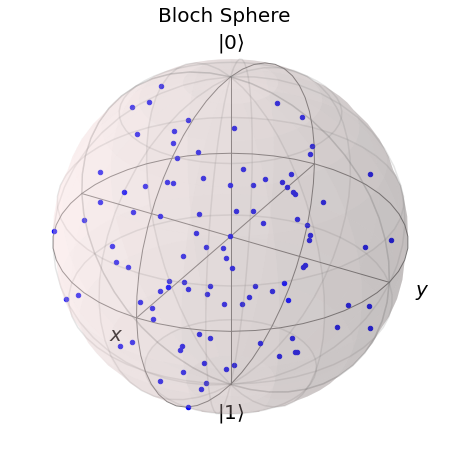

In [15]:
#VISUALIZE DATA ON BLOCH SPHERE
Bloch_sphere(bloch_vectors_noise_free)

In [16]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [17]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

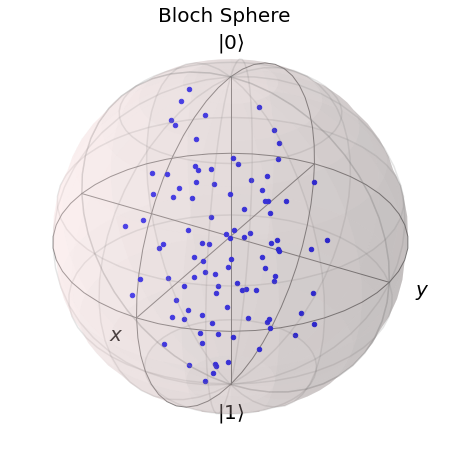

In [18]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
Bloch_sphere(bloch_vectors_with_noise)

In [19]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:30], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:30], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [20]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3)
  ])

In [21]:
# Define Loss
loss_fn = tf.keras.losses.mse
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=loss_fn)

In [22]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 193ms/step - loss: 0.1706 - val_loss: 0.1463
Epoch 2/200
3/3 [==============================] - 0s 36ms/step - loss: 0.1554 - val_loss: 0.1327
Epoch 3/200
3/3 [==============================] - 0s 49ms/step - loss: 0.1418 - val_loss: 0.1198
Epoch 4/200
3/3 [==============================] - 0s 60ms/step - loss: 0.1283 - val_loss: 0.1079
Epoch 5/200
3/3 [==============================] - 0s 48ms/step - loss: 0.1155 - val_loss: 0.0966
Epoch 6/200
3/3 [==============================] - 0s 58ms/step - loss: 0.1026 - val_loss: 0.0855
Epoch 7/200
3/3 [==============================] - 0s 49ms/step - loss: 0.0915 - val_loss: 0.0748
Epoch 8/200
3/3 [==============================] - 0s 45ms/step - loss: 0.0796 - val_loss: 0.0648
Epoch 9/200
3/3 [==============================] - 0s 41ms/step - loss: 0.0692 - val_loss: 0.0551
Epoch 10/200
3/3 [==============================] - 0s 34ms/step - loss: 0.0586 - val_loss: 0.0460
Epoch 11/200
3/3 [

3/3 [==============================] - 0s 48ms/step - loss: 2.5296e-04 - val_loss: 0.0019
Epoch 82/200
3/3 [==============================] - 0s 44ms/step - loss: 2.4936e-04 - val_loss: 0.0019
Epoch 83/200
3/3 [==============================] - 0s 40ms/step - loss: 2.4413e-04 - val_loss: 0.0019
Epoch 84/200
3/3 [==============================] - 0s 36ms/step - loss: 2.4251e-04 - val_loss: 0.0019
Epoch 85/200
3/3 [==============================] - 0s 36ms/step - loss: 2.4025e-04 - val_loss: 0.0019
Epoch 86/200
3/3 [==============================] - 0s 40ms/step - loss: 2.3449e-04 - val_loss: 0.0019
Epoch 87/200
3/3 [==============================] - 0s 41ms/step - loss: 2.3372e-04 - val_loss: 0.0019
Epoch 88/200
3/3 [==============================] - 0s 40ms/step - loss: 2.2725e-04 - val_loss: 0.0018
Epoch 89/200
3/3 [==============================] - 0s 40ms/step - loss: 2.2868e-04 - val_loss: 0.0018
Epoch 90/200
3/3 [==============================] - 0s 35ms/step - loss: 2.2323e-04 - 

3/3 [==============================] - 0s 40ms/step - loss: 9.0238e-05 - val_loss: 0.0015
Epoch 161/200
3/3 [==============================] - 0s 40ms/step - loss: 9.0839e-05 - val_loss: 0.0015
Epoch 162/200
3/3 [==============================] - 0s 36ms/step - loss: 8.7784e-05 - val_loss: 0.0015
Epoch 163/200
3/3 [==============================] - 0s 45ms/step - loss: 8.5359e-05 - val_loss: 0.0015
Epoch 164/200
3/3 [==============================] - 0s 41ms/step - loss: 8.5693e-05 - val_loss: 0.0015
Epoch 165/200
3/3 [==============================] - 0s 38ms/step - loss: 8.2804e-05 - val_loss: 0.0015
Epoch 166/200
3/3 [==============================] - 0s 40ms/step - loss: 8.2666e-05 - val_loss: 0.0015
Epoch 167/200
3/3 [==============================] - 0s 36ms/step - loss: 8.3076e-05 - val_loss: 0.0015
Epoch 168/200
3/3 [==============================] - 0s 40ms/step - loss: 8.1179e-05 - val_loss: 0.0015
Epoch 169/200
3/3 [==============================] - 0s 44ms/step - loss: 8.01

In [23]:
score = model.evaluate(x_test,  y_test, verbose=2)

1/1 - 0s - loss: 6.2668e-04 - 176ms/epoch - 176ms/step


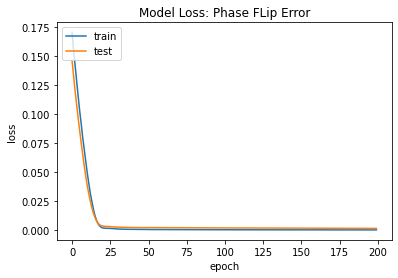

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
#save the model predictions in a tensor
y_prediction = model(x_test)
#CHANGE TYPE OF PREDICTION IN COMPLEX ONE
y_prediction = tf.cast(y_prediction, tf.complex128)
#CHANGE TYPE OF IDEAL CASE IN COMPLEX ONE
y_test = tf.cast(y_test, tf.complex128)


fidelities = []

for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)


  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)

for i in range(len(x_test)):
  print(i, "Vector noise-less: {}, Noisy vector: {}, Vector predicted: {}".format(y_test[i],x_test[i],y_prediction[i]))
  print(i, "Fidelity: {}".format(np.real(fidelities[i])))

print(tf.math.reduce_mean(fidelities))

0 Vector noise-less: [0.55524997+0.j 0.67631193+0.j 0.08553953+0.j], Noisy vector: [0.33314998 0.40578716 0.08553953], Vector predicted: [0.54742974+0.j 0.65465683+0.j 0.07920368+0.j]
0 Fidelity: 0.999480832902752
1 Vector noise-less: [ 0.11074081+0.j -0.09287368+0.j -0.35171464+0.j], Noisy vector: [ 0.06644449 -0.05572421 -0.35171464], Vector predicted: [ 0.11395065+0.j -0.09723051+0.j -0.37412298+0.j]
1 Fidelity: 0.9998437137512451
2 Vector noise-less: [ 0.7395033 +0.j -0.29166745+0.j  0.12561174+0.j], Noisy vector: [ 0.44370198 -0.17500047  0.12561174], Vector predicted: [ 0.73623413+0.j -0.295544  +0.j  0.13776332+0.j]
2 Fidelity: 0.9999565804063518
3 Vector noise-less: [-0.47918152+0.j  0.2234984 +0.j -0.36615282+0.j], Noisy vector: [-0.28750891  0.13409904 -0.36615282], Vector predicted: [-0.48610333+0.j  0.21127252+0.j -0.38412741+0.j]
3 Fidelity: 0.9998460684190373
4 Vector noise-less: [-0.49395463+0.j -0.24898245+0.j -0.14776703+0.j], Noisy vector: [-0.29637278 -0.14938947 -0.